In this competition, you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador.

# EDA for the train.csv data (estimated time was 2.5 hours)

The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

## Remarks

 - We have no null values
 - The sales data includes sales to 54 different stores across 33 product families
 - We have sales from 1st January 2013 to the 15th of August of 2017
 - All store_nbr have the same dates available, but not all of them have sales for the whole time period. Some of the stores are buying for less than 3 years. And one, store 52, has less than 1 year of data available.
 - Top 5 stores by total sales: 44 (6.208755e+07), 45, 47, 3 and 49 (4.342010e+07)  
 - Bottom 5 stores by total sales: 35 (7.676679e+06), 30 , 32 , 22 and 52 (2.696170e+06)
     - From these, store 52 has less than one year of sales, so it is the newest one.
 - All stores buy products from almost the same number of families, ranging from 30 to 33

## Wrap-up

We need to predict the total number of sales by product family to each particular store by day. The challenge here is that there are 54 stores, each selling from 30 to 34 families of products. This amounts to fitting at least 54\*30 = 1620 models if we go for a naive approach.

The product families include grouppings that will behave differently across the year. For instance, the groceries and beverages families have very strong seasonalities, but might not be very sensible to special offers or promotions. Whereas more specialized items, like automotive, or home appliances might be less influenced by seasonality and more by special offers. I also expect that the later types of families will be significantly harder to predict than the most seasonal ones.

Other than that, it seems that not a lot of preprocessing needs to be done in this case and we proceed to create a benchmark model.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates
import pandas_profiling

import os

DATA_FOLDER = '/home/jeronimo/Desktop/Freshflow_techChallenge/store_sales_forecasting/data'

In [4]:
train = pd.read_csv(os.path.join(DATA_FOLDER, 'train.csv'))
print(train.shape)
train.head()

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


We can see the time-series structure of the data. From here, the **id** column is not needed because it is the same as the index, and the store_nbr is an indicator variable, so we will use it as a string variable. We setup the dates in the correct format.

In [2]:
dtype_map = {'id':str, 'date':str, 'store_nbr':str, 'family':str,
             'sales':float, 'onpromotion':int}
train = pd.read_csv(os.path.join(DATA_FOLDER, 'train.csv'), dtype=dtype_map)
train.drop('id', axis=1, inplace=True)
train['date'] = pd.to_datetime(train.date, errors='coerce', format='%Y-%m-%d')

print(train.shape)
train.head()

(3000888, 5)


,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [42]:
train.isnull().sum()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [43]:
train.select_dtypes(include='object').describe()

,store_nbr,family
count,3000888,3000888
unique,54,33
top,1,AUTOMOTIVE
freq,55572,90936


In [44]:
train.select_dtypes(exclude='object').describe(datetime_is_numeric=True)

,date,sales,onpromotion
count,3000888,3.000888e+06,3.000888e+06
mean,2015-04-24 08:27:04.703088384,3.577757e+02,2.602770e+00
min,2013-01-01 00:00:00,0.000000e+00,0.000000e+00
25%,2014-02-26 18:00:00,0.000000e+00,0.000000e+00
50%,2015-04-24 12:00:00,1.100000e+01,0.000000e+00
75%,2016-06-19 06:00:00,1.958473e+02,0.000000e+00
max,2017-08-15 00:00:00,1.247170e+05,7.410000e+02
std,NaN,1.101998e+03,1.221888e+01


# Count the number of dates available per store

In [50]:
train.groupby('store_nbr').date.count().sort_values(ascending=False).tail()

store_nbr
29    55572
3     55572
30    55572
31    55572
9     55572
Name: date, dtype: int64

## Number of non-zero sales dates available per store

In [133]:
store_Ndays = train[train.sales!=0].groupby('store_nbr').agg({'date':[min, max]})
store_Ndays.columns = ['date_min', 'date_max']
store_Ndays['ndays'] = store_Ndays.date_max-store_Ndays.date_min
store_Ndays = store_Ndays.sort_values('ndays')
pd.concat([store_Ndays.head(), store_Ndays.tail()])

,date_min,date_max,ndays
store_nbr,,,
52,2017-04-20,2017-08-15,117 days
22,2015-10-09,2017-08-15,676 days
42,2015-08-21,2017-08-15,725 days
21,2015-07-24,2017-08-15,753 days
29,2015-03-20,2017-08-15,879 days
32,2013-01-02,2017-08-15,1686 days
8,2013-01-02,2017-08-15,1686 days
23,2013-01-02,2017-08-15,1686 days
9,2013-01-02,2017-08-15,1686 days


# Sales distribution

<AxesSubplot: >

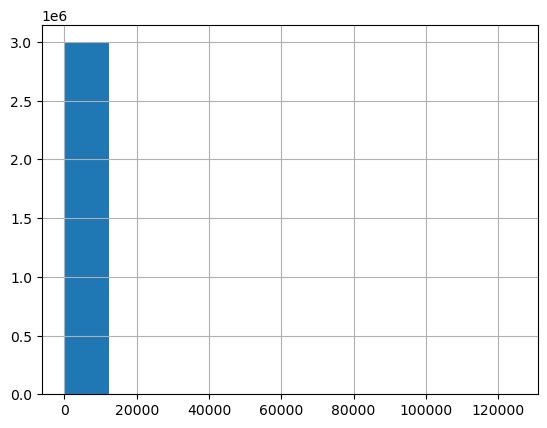

In [169]:
# most of the time only a small number of sales are made
train.sales.hist()

<AxesSubplot: >

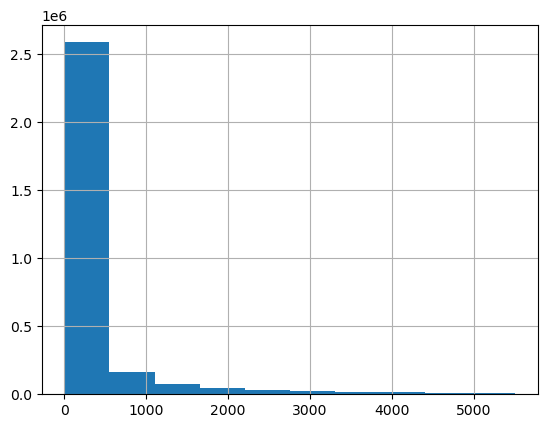

In [171]:
train[train.sales<train.sales.quantile(0.99)].sales.hist()

## Per store_nbr

In [47]:
store_sales = train.groupby('store_nbr').sales.sum().sort_values(ascending=False)
# Top 5 best
top_sales = store_sales.head()
bottom_sales = store_sales.tail()

pd.concat([top_sales, bottom_sales])

store_nbr
44    6.208755e+07
45    5.449801e+07
47    5.094831e+07
3     5.048191e+07
49    4.342010e+07
35    7.676679e+06
30    7.382074e+06
32    5.951796e+06
22    4.090202e+06
52    2.696170e+06
Name: sales, dtype: float64

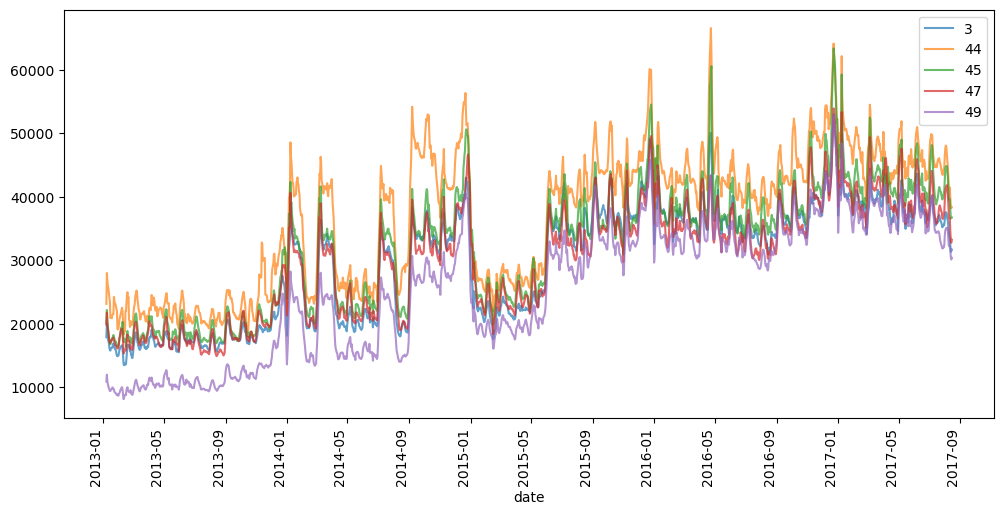

In [131]:
top_df = train[train.store_nbr.isin(top_sales.index)]
top_df = top_df.groupby(['store_nbr', 'date'], as_index=False).sales.sum().set_index('date')


fig, ax = plt.subplots(figsize=(12, 6))

for idx, g in top_df.groupby('store_nbr'):
    g['sales_rolling'] = g.sales.rolling(7).mean()
    g.plot(y='sales_rolling', ax=ax, label=idx, alpha=0.7)

# show every 4th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.xticks(rotation=90)
plt.show()

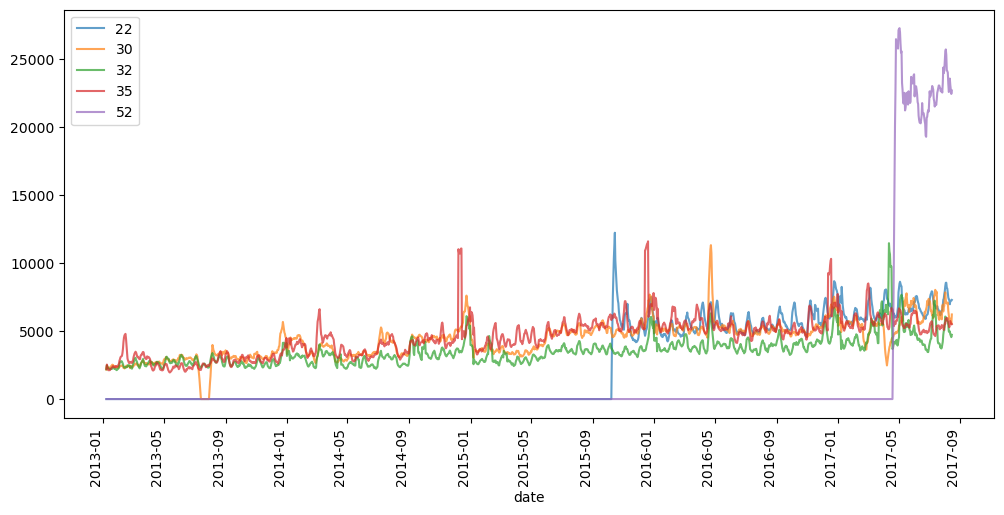

In [132]:
bottom_df = train[train.store_nbr.isin(bottom_sales.index)]
bottom_df = bottom_df.groupby(['store_nbr', 'date'], as_index=False).sales.sum().set_index('date')

fig, ax = plt.subplots(figsize=(12, 6))

for idx, g in bottom_df.groupby('store_nbr'):
    g['sales_rolling'] = g.sales.rolling(7).mean()
    g.plot(y='sales_rolling', ax=ax, label=idx, alpha=0.7)

# show every 4th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.xticks(rotation=90)
plt.show()

## Seasonal decomposition of average sales from best and worst stores by Month

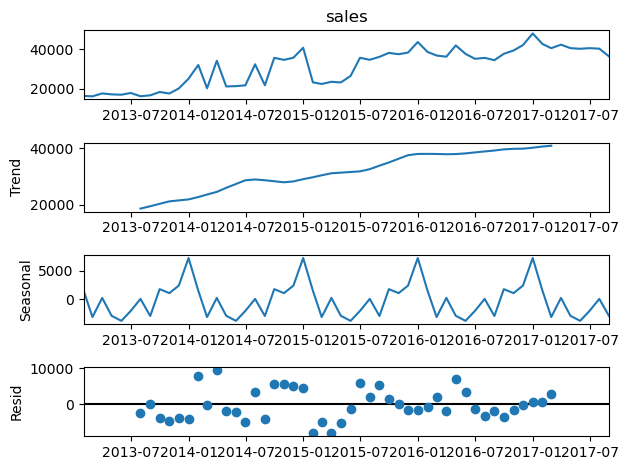

In [163]:
from statsmodels.tsa.seasonal import seasonal_decompose

avg_topSales = top_df.resample('M').sales.mean().fillna(0)

ts_decomposed = seasonal_decompose(avg_topSales)

ts_decomposed.plot()
plt.show()

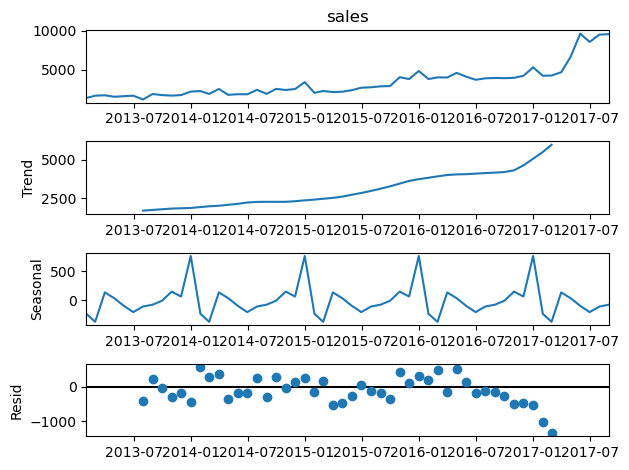

In [164]:
from statsmodels.tsa.seasonal import seasonal_decompose

avg_bottomSales = bottom_df.resample('M').sales.mean().fillna(0)

ts_decomposed = seasonal_decompose(avg_bottomSales)

ts_decomposed.plot()
plt.show()

## By family

In [204]:
store_Nfamily = train[train.sales!=0].groupby('store_nbr').family.nunique()
store_Nfamily.sort_values()

store_nbr
54    30
33    31
29    31
28    31
35    31
40    31
43    31
32    31
30    31
16    31
14    31
13    31
52    31
48    32
47    32
45    32
44    32
50    32
39    32
36    32
34    32
51    32
49    32
46    32
1     32
20    32
10    32
11    32
12    32
15    32
17    32
18    32
19    32
31    32
21    32
22    32
9     32
25    32
23    32
7     33
6     33
8     33
53    33
27    33
26    33
41    33
5     33
37    33
38    33
24    33
2     33
4     33
42    33
3     33
Name: family, dtype: int64

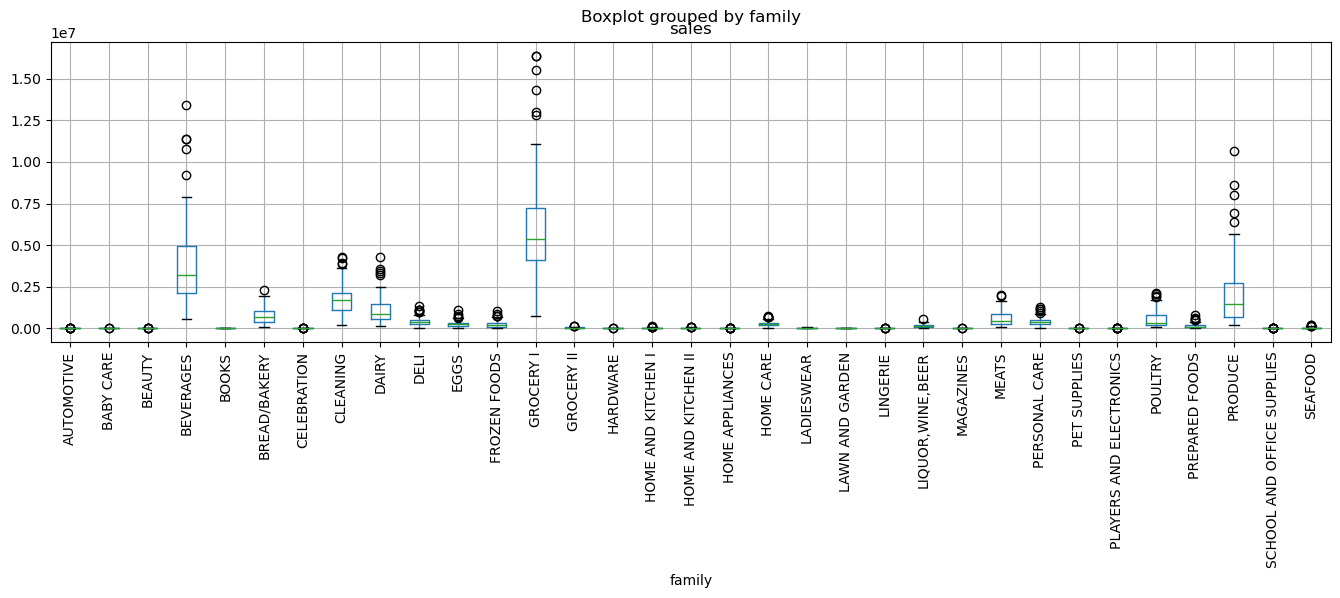

In [179]:
family_sales = train[train.sales!=0].groupby(['store_nbr', 'family'], as_index=False).sales.sum()
family_sales.boxplot(column='sales', by='family', figsize=(16, 4))
plt.xticks(rotation=90)
plt.show()

In [260]:
pivot_familySales = family_sales.pivot_table(index='store_nbr', columns='family', values='sales')

all_topFam = []
for i, row in pivot_familySales.iterrows():
    aux = row.sort_values(ascending=False)[0:3].index.to_list()
    all_topFam += aux
    
all_topFam = np.unique(all_topFam)
all_topFam

array(['BEVERAGES', 'CLEANING', 'GROCERY I', 'PRODUCE'], dtype='<U9')

<AxesSubplot: xlabel='store_nbr'>

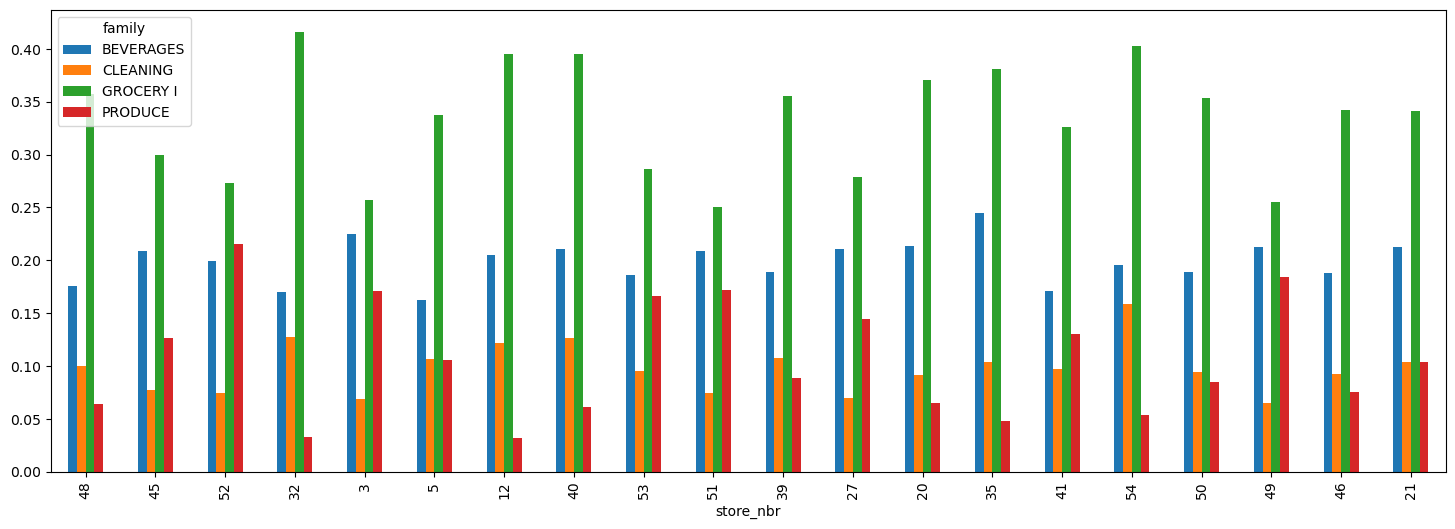

In [261]:
sample = pivot_familySales.div(pivot_familySales.sum(1), 0).sample(20)
sample = sample[all_topFam]
sample.plot.bar(figsize=(18, 6))

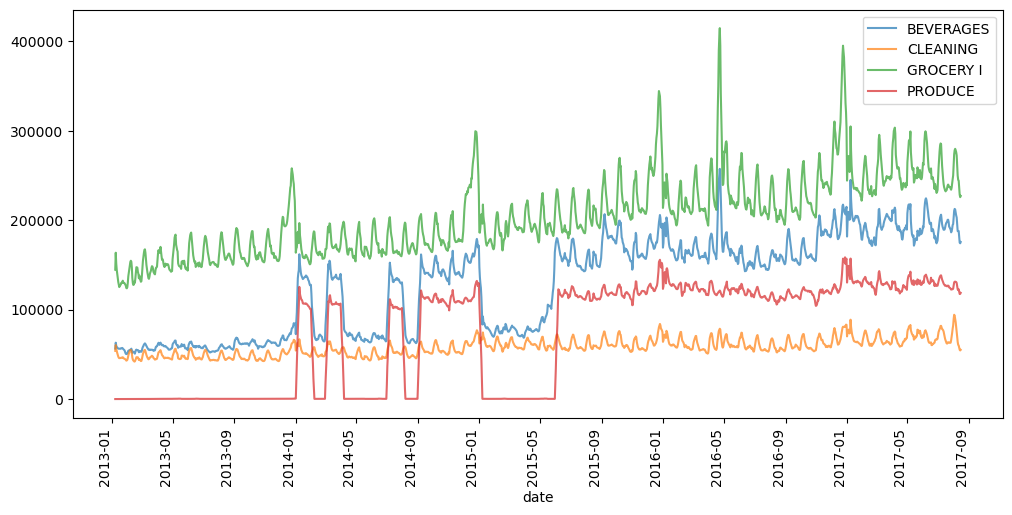

In [262]:
topFamily_df = train[train.family.isin(all_topFam)]
topFamily_df = topFamily_df.groupby(['family', 'date'], as_index=False).sales.sum().set_index('date')

fig, ax = plt.subplots(figsize=(12, 6))

for idx, g in topFamily_df.groupby('family'):
    g['sales_rolling'] = g.sales.rolling(7).mean()
    g.plot(y='sales_rolling', ax=ax, label=idx, alpha=0.7)

# show every 4th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.xticks(rotation=90)
plt.show()